In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import linear_model
from tqdm import tqdm_notebook as tqdm

import ampy
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
alpha = 0.8
N = 4096
M = int(N * alpha)

A = np.random.normal(0.0, 1.0/ N**0.5, (M, N))
x_0 = np.random.normal(0.0, 1.0, N)
x_0 = np.random.binomial(1.0, 0.1, N) * x_0
y = A @ x_0 + np.random.normal(0.0, 1e-2, M)

In [4]:
lasso_cv = linear_model.LassoCV(cv=5, n_jobs=2, tol=1e-5)
lasso_cv.fit(A, y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=2, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=1e-05,
    verbose=False)

In [5]:
lasso = linear_model.Lasso(alpha=lasso_cv.alpha_, tol=1e-12, max_iter=1e5)
lasso.fit(A, y)

Lasso(alpha=2.6962904272852134e-06, copy_X=True, fit_intercept=True,
   max_iter=100000.0, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=1e-12, warm_start=False)

No handles with labels found to put in legend.


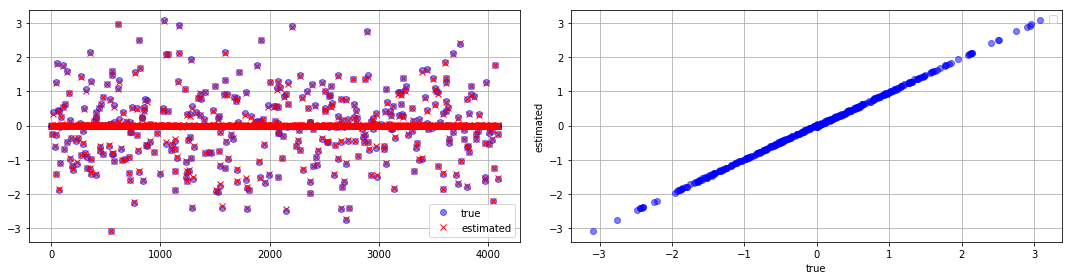

In [6]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121)
ax.plot(x_0, "o", c="b", alpha =0.5, label="true")
ax.plot(lasso.coef_, "x", c="r", label="estimated")
ax.grid()
ax.legend()

ax = fig.add_subplot(122)
ax.plot(x_0, lasso.coef_, "o", c="b", alpha=0.5)
ax.set_xlabel("true")
ax.set_ylabel("estimated")
ax.grid()
ax.legend()

fig.tight_layout()

In [7]:
lasso = linear_model.Lasso(alpha=lasso_cv.alpha_, tol=1e-12, max_iter=1e5, warm_start=True)
l_list = lasso_cv.alpha_ * np.logspace(2, 0, base=10.0, num=100)
solution_lasso_list = []
lasso.alpha = l_list[0]
lasso.fit(A, y)
t1 = time.time()
for l in tqdm(l_list[1:]):
    lasso.alpha = l
    lasso.fit(A, y)
t2 = time.time()
print(t2 - t1, "sec")



42.555914878845215 sec


In [13]:
dumping = 0.95
tol = 1e-3
max_iteration = 100

l_list = M * lasso_cv.alpha_ * np.logspace(2, 0, base=10.0, num=100)
vamp_solver = ampy.SelfAveragingLMMSEVAMPSolver.SelfAveragingLMMSEVAMPSolver(A, y, l_list[0], dumping)

vamp_solver.d = 0.95
vamp_solver.solve(max_iteration=max_iteration, tolerance=tol)
vamp_solver.d = dumping

solution_list = []
t1 = time.time()
for i, l in tqdm(enumerate(l_list[1:]), total=len(l_list[1:])):
    vamp_solver.l = l
    vamp_solver.solve(max_iteration=max_iteration, tolerance=tol, message=False)
    solution_list.append(vamp_solver.x_hat_1.copy())
#     print()
t2 = time.time()
print(t2 - t1, "sec")


4.01211404800415 sec


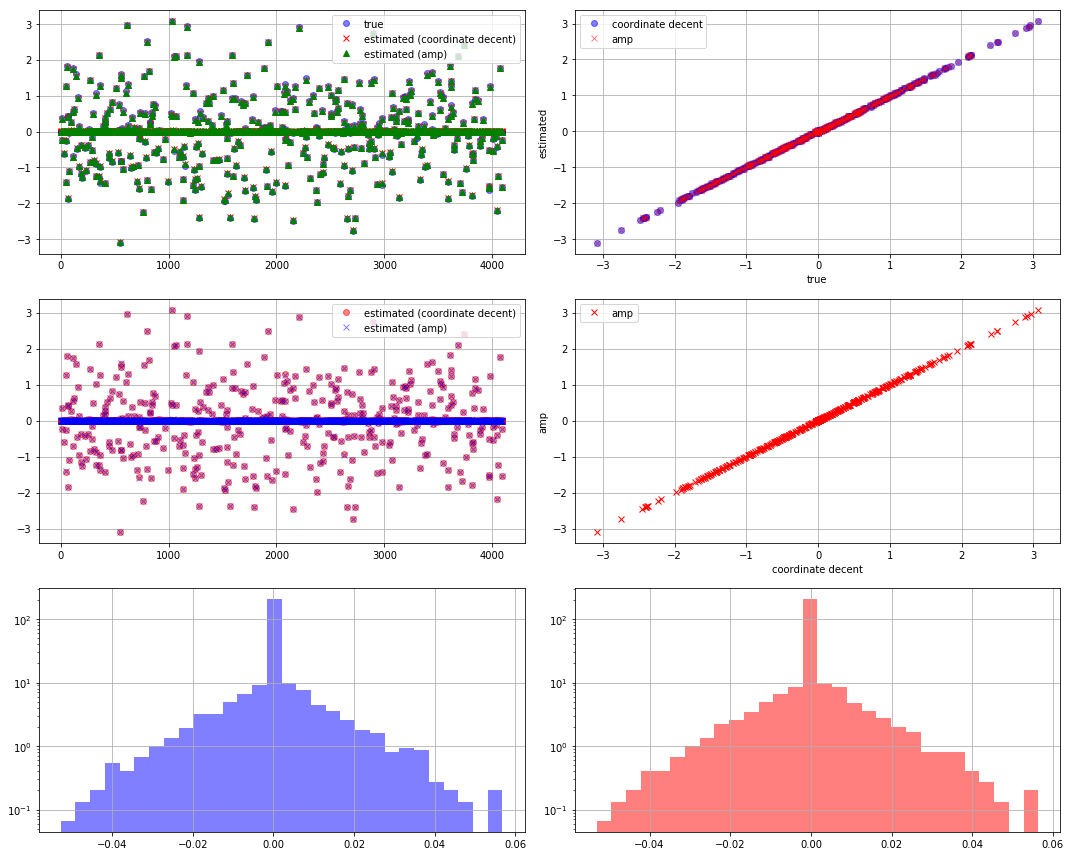

In [14]:

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(321)
ax.plot(x_0, "o", c="b", alpha =0.5, label="true")
ax.plot(lasso.coef_, "x", c="r", label="estimated (coordinate decent)")
ax.plot(vamp_solver.x_hat_1, "^", c="g", label="estimated (amp)")
ax.grid()
ax.legend()

ax = fig.add_subplot(322)
ax.plot(x_0, lasso.coef_, "o", c="b", alpha=0.5, label="coordinate decent")
ax.plot(x_0, vamp_solver.x_hat_1, "x", c="r", label="amp", alpha=0.5)
ax.set_xlabel("true")
ax.set_ylabel("estimated")
ax.grid()
ax.legend()

ax = fig.add_subplot(323)
ax.plot(lasso.coef_, "o", c="r", label="estimated (coordinate decent)", alpha=0.5)
ax.plot(vamp_solver.x_hat_1, "x", c="b", label="estimated (amp)", alpha=0.5)
ax.grid()
ax.legend()

ax = fig.add_subplot(324)
ax.plot(lasso.coef_, vamp_solver.x_hat_1, "x", c="r", label="amp")
ax.set_xlabel("coordinate decent")
ax.set_ylabel("amp")
ax.grid()
ax.legend()

ax = fig.add_subplot(325)
ax.hist(x_0 - lasso.coef_, density=True, bins=30, log=True, facecolor="b", alpha=0.5)
ax.grid()

ax = fig.add_subplot(326)
ax.hist(x_0 - vamp_solver.x_hat_1, density=True, bins=30, log=True, facecolor="r", alpha=0.5)
ax.grid()


fig.tight_layout()

In [10]:
tol = 1e-4
max_iteration = 100

l_list = M * lasso_cv.alpha_ * np.logspace(2, 0, base=10.0, num=100)
vamp_solver = ampy.SelfAveragingLMMSEVAMPSolver.SelfAveragingLMMSEVAMPSolver(A, y, l_list[0], dumping)

vamp_solver.d = 0.95
vamp_solver.solve(max_iteration=max_iteration, tolerance=tol)


array([-1.92318935e-10, -2.26509819e-09,  8.26129156e-10, ...,
        3.05047145e-11, -5.15827977e-01,  7.48428908e-11])

In [11]:
vamp_solver.d = 0.95
# vamp_solver.d = 1.1
vamp_solver.l = l_list[-1]
estimator_list = []
gamma_1_list = []
gamma_2_list = []
for i in tqdm(range(50)):
    estimator = vamp_solver.solve(max_iteration=1, tolerance=tol)
    gamma_1_list.append(vamp_solver.gamma_1)
    gamma_2_list.append(vamp_solver.gamma_2)
    estimator_list.append(estimator)
diff_list = []
for estimator in estimator_list:
    diff = np.linalg.norm(x_0 - estimator)**2 / np.linalg.norm(x_0)**2
    diff_list.append(diff)

does not converged.
abs_diff= 0.34133722565237934
estimate norm= 26.218197195067972
relative diff=  0.013019095977986995
iteration num= 1

does not converged.
abs_diff= 0.43313336839068317
estimate norm= 16.058753482000746
relative diff=  0.026971792603713313
iteration num= 1

does not converged.
abs_diff= 0.24977834632530785
estimate norm= 19.573236496447215
relative diff=  0.012761218430618039
iteration num= 1

does not converged.
abs_diff= 0.0694497105975252
estimate norm= 20.651260428324008
relative diff=  0.0033629768429181304
iteration num= 1

does not converged.
abs_diff= 0.03319349956343939
estimate norm= 20.824596640932924
relative diff=  0.0015939564225793497
iteration num= 1

does not converged.
abs_diff= 0.013151156205528796
estimate norm= 21.15336260909452
relative diff=  0.0006217052318610889
iteration num= 1

does not converged.
abs_diff= 0.006071779256453519
estimate norm= 21.27048611175844
relative diff=  0.00028545559441149805
iteration num= 1

does not converged.
abs

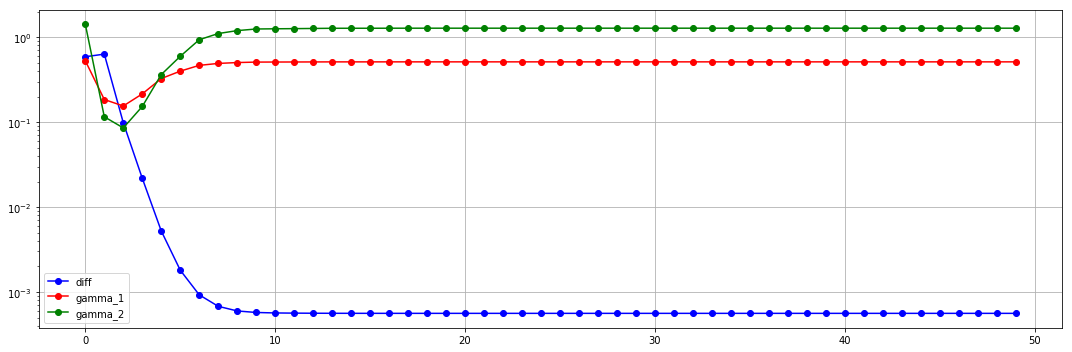

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(diff_list, "-o", c="b", label="diff")
ax.plot(gamma_1_list, "-o", c="r", label="gamma_1")
ax.plot(gamma_2_list, "-o", c="g", label="gamma_2")
ax.legend()
ax.set_yscale("log")

ax.grid()
fig.tight_layout()